### Tasks:
1.Model to predict the Genre using given book dataset

2.Model which predict the rating for the book which help in making trending and sorting

## Task1: Genre prediction

In [1]:
#required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

import re
import string
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB


from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix,classification_report

In [2]:
#loading the given dataset

data = pd.read_csv('DA-AI-ML-interview-assignment-Data.csv')
data.head(10)

,Unnamed: 0,title,rating,name,num_ratings,num_reviews,num_followers,synopsis,genre
0,0,Sapiens: A Brief History of Humankind,4.39,Yuval Noah Harari,"8,06,229","46,149",30.5k,"100,000 years ago, at least six human species ...",history
1,1,"Guns, Germs, and Steel: The Fates of Human Soc...",4.04,Jared Diamond,"3,67,056","12,879","6,538","""Diamond has written a book of remarkable scop...",history
2,2,A People's History of the United States,4.07,Howard Zinn,"2,24,620","6,509","2,354","In the book, Zinn presented a different side o...",history
3,3,"The Devil in the White City: Murder, Magic, an...",3.99,Erik Larson,"6,13,157","36,644",64.2k,Author Erik Larson imbues the incredible event...,history
4,4,The Diary of a Young Girl,4.18,Anne Frank,"33,13,033","35,591","4,621",Discovered in the attic in which she spent the...,history
5,5,1776,4.08,David McCullough,"2,14,796","7,910","9,137","In this masterful book, David McCullough tells...",history
6,6,A Short History of Nearly Everything,4.20,Bill Bryson,"3,52,894","14,428",18.3k,Bill Bryson describes himself as a reluctant t...,history
7,7,The Rise and Fall of the Third Reich: A Histor...,4.18,William L. Shirer,"1,21,138","3,473",711,Hitler boasted that The Third Reich would last...,history
8,8,1491: New Revelations of the Americas Before C...,4.03,Charles C. Mann,"79,347","4,429",902,"In this groundbreaking work of science, histor...",history
9,9,SPQR: A History of Ancient Rome,4.03,Mary Beard,"51,423","3,536","2,786","In SPQR, an instant classic, Mary Beard narrat...",history


In [3]:
data = data.drop('Unnamed: 0',axis = 1)

### Raw analysis of give dataset

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1539 entries, 0 to 1538
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   title          1539 non-null   object 
 1   rating         1539 non-null   float64
 2   name           1539 non-null   object 
 3   num_ratings    1539 non-null   object 
 4   num_reviews    1539 non-null   object 
 5   num_followers  1539 non-null   object 
 6   synopsis       1539 non-null   object 
 7   genre          1539 non-null   object 
dtypes: float64(1), object(7)
memory usage: 96.3+ KB


#### Observation
We can observe that in our dataset their is no persence of NaN values and includes 1539 data with 7 features in it.

In our task1 we have to consider the Genre as target set as our aim to predict genre

In [5]:
target = data[['genre']]

thriller           481
fantasy            348
romance            111
horror             100
history             99
psychology          99
travel              98
science             79
sports              79
science_fiction     45
Name: genre, dtype: int64
 


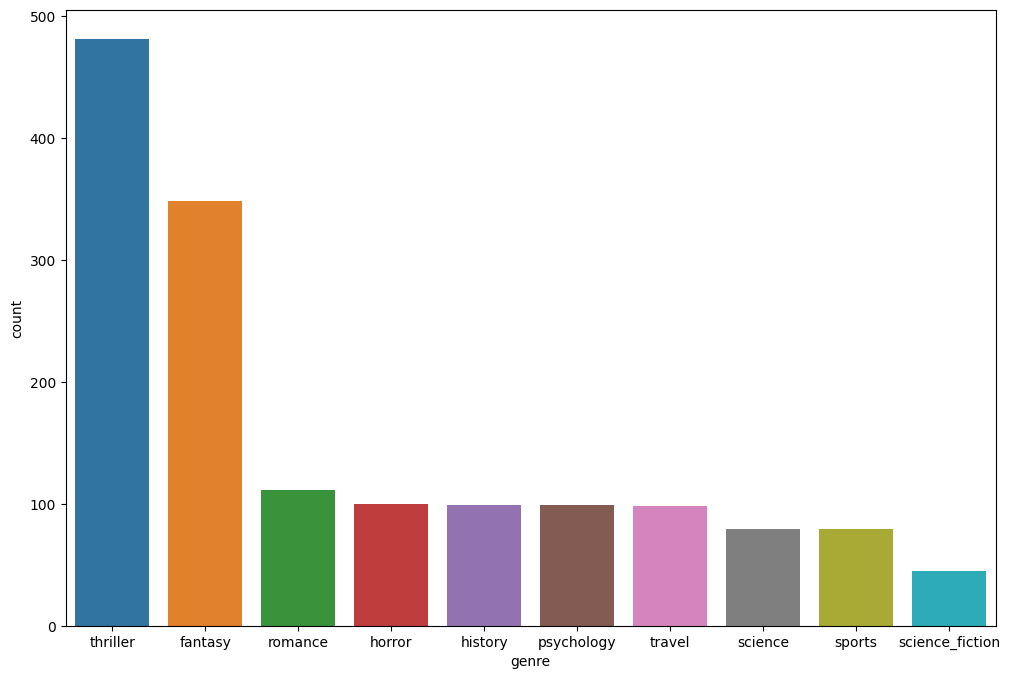

In [6]:
print(target.genre.value_counts())
print(" ")
plt.figure(figsize=(12,8))
sb.countplot(x=target['genre'], order=target['genre'].value_counts().index)
plt.show()

Further we consider only Synopsis as predictor out other 6 features[title,name,ratings,reviews and flowers] as rating ,reviews flowers are irrelevent features
for predicting the genre of book and,remaining name of author may contain my genre out of books in library and which might not contain in our dataset and leads to model
bias.Synopsis of book[title] gives the summary which help in extracting meaning full details than title of book so we consider only synopsis and apply NLP techniques for 
feature extraction and preprocess

Why NLP not other categorical encoding techniques ?

Because NLP helps to create less dimesioned meagning full vectors out of text dataset and other categorical encoding techniques creates high dimesion features which affects in creating 
generalized model for classification

In [7]:
feature = data[['synopsis']]

## Data preprocess
steps:

    1. Transvers all synopsis and removes non alphabitics characters and puncuations 
    2. Removing stopwords
    3. Stemming and lemmatization
    4. Creating vectors for lemmateized data using [bagofword or tfidf or word2vec]

In [8]:
#function which removes the non alphabetic charactes and other non required characters
def clean_nonalph(text):
    # remove backslash-apostrophe 
    text = re.sub("\'", "", text) 
    # remove everything except alphabets 
    text = re.sub("[^a-zA-Z]"," ",text) 
    # remove whitespaces 
    text = ' '.join(text.split()) 
    # convert text to lowercase 
    text = text.lower() 
    
    return text

feature.loc[:,'synopsis']= feature.loc[:,'synopsis'].apply(lambda x: clean_nonalph(x))

/tmp/ipykernel_253/3752004618.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature.loc[:,'synopsis']= feature.loc[:,'synopsis'].apply(lambda x: clean_nonalph(x))


In [9]:
feature.synopsis[5]

'in this masterful book david mccullough tells the intensely human story of those who marched with general george washington in the year of the declaration of independence when the whole american cause was riding on their success without which all hope for independence would have been dashed and the noble ideals of the declaration would have amounted to little more than words on paper based on extensive research in both american and british archives is a powerful drama written with extraordinary narrative vitality it is the story of americans in the ranks men of every shape size and color farmers schoolteachers shoemakers no accounts and mere boys turned soldiers and it is the story of the kings men the british commander william howe an his highly disciplined redcoats who looked on their rebel foes with contempt and fought with a valor too little known at the center of the drama with washington are two young american patriots who at first knew no more of war than what they had read in 

We can observe that text is converted to lowercase and all irrelevent character and punctuation were removed

In [10]:
# removing stopwords
nltk.download('stopwords')

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# function to remove stopwords
def removestopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

feature['synopsis'] = feature['synopsis'].apply(lambda x: removestopwords(x))

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/adithyasab99ine/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/tmp/ipykernel_253/2468568566.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature['synopsis'] = feature['synopsis'].apply(lambda x: removestopwords(x))


In [11]:
feature.synopsis[5]

'masterful book david mccullough tells intensely human story marched general george washington year declaration independence whole american cause riding success without hope independence would dashed noble ideals declaration would amounted little words paper based extensive research american british archives powerful drama written extraordinary narrative vitality story americans ranks men every shape size color farmers schoolteachers shoemakers accounts mere boys turned soldiers story kings men british commander william howe highly disciplined redcoats looked rebel foes contempt fought valor little known center drama washington two young american patriots first knew war read books nathaniel green quaker made general thirty three henry knox twenty five year old bookseller preposterous idea hauling guns fort ticonderoga overland boston dead winter american commander chief stands foremost washington never led army battle written companion work celebrated biography john adams david mccullo

In [12]:
# Lemmatization : it groups different versions of the same word into one – for example, finalzed/finaling/final to final
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
lemma=WordNetLemmatizer()
def lematizing(sentence):
    stemSentence = ""
    for word in sentence.split():
        stem = lemma.lemmatize(word)
        stemSentence += stem
        stemSentence += " "
    stemSentence = stemSentence.strip()
    return stemSentence

feature['synopsis'] = feature['synopsis'].apply(lambda x: lematizing(x))
stemmer = PorterStemmer()
def stemming(sentence):
    stemSentence = ""
    for word in sentence.split():
        stem = stemmer.stem(word)
        stemSentence += stem
        stemSentence += " "
    stemSentence = stemSentence.strip()
    return stemSentence

feature['synopsis'] = feature['synopsis'].apply(lambda x: stemming(x))


[nltk_data] Downloading package wordnet to
[nltk_data]     /home/adithyasab99ine/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/tmp/ipykernel_253/3580378054.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature['synopsis'] = feature['synopsis'].apply(lambda x: lematizing(x))
/tmp/ipykernel_253/3580378054.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature['synopsis'] = feature['synopsis'].apply(lambda x: stemming(x))


In [13]:
feature.synopsis[5]

'master book david mccullough tell intens human stori march gener georg washington year declar independ whole american caus ride success without hope independ would dash nobl ideal declar would amount littl word paper base extens research american british archiv power drama written extraordinari narr vital stori american rank men everi shape size color farmer schoolteach shoemak account mere boy turn soldier stori king men british command william howe highli disciplin redcoat look rebel foe contempt fought valor littl known center drama washington two young american patriot first knew war read book nathaniel green quaker made gener thirti three henri knox twenti five year old booksel preposter idea haul gun fort ticonderoga overland boston dead winter american command chief stand foremost washington never led armi battl written companion work celebr biographi john adam david mccullough anoth landmark literatur american histori'

## categorical Encoding 

##### Converting the text to vectors using TF*IDF 
"TF = No. of repetation of words in sentence/No. of words in sentence
IDF =  log(No. of Sentence /No. of Sentence containing words)

TF*IDF"

In [14]:
#spliting the dataset into 80 / 20 percentage
X_train, X_test , y_train, y_test = train_test_split(feature['synopsis'].values,target['genre'].values,test_size=0.2,random_state=42)

In [15]:
X_train.shape,X_test.shape

((1231,), (308,))

In [16]:
vectorizer = TfidfVectorizer()
train_vectors = vectorizer.fit_transform(X_train)
test_vectors = vectorizer.transform(X_test)
analyze = vectorizer.build_analyzer()

In [17]:
#Aanalyze the important words for sysnopsis 5
print(analyze(X_train[5]))

['let', 'prove', 'worthi', 'man', 'newli', 'knight', 'alanna', 'trebond', 'seek', 'adventur', 'vast', 'desert', 'tortal', 'captur', 'fierc', 'desert', 'dweller', 'forc', 'prove', 'duel', 'death', 'either', 'kill', 'induct', 'tribe', 'although', 'triumph', 'dire', 'challeng', 'lie', 'ahead', 'mythic', 'fate', 'would', 'alanna', 'soon', 'becom', 'tribe', 'first', 'femal', 'shaman', 'despit', 'desert', 'dweller', 'grave', 'fear', 'foreign', 'woman', 'warrior', 'alanna', 'must', 'fight', 'chang', 'ancient', 'tribal', 'custom', 'desert', 'tribe', 'sake', 'sake', 'tortal', 'alanna', 'journey', 'continu', 'le']


## Model Training

In [18]:
models = {
          "SVM": svm.SVC(kernel = 'linear'),
          "RandomForestClassifier": RandomForestClassifier(),
          "MultiNB":  MultinomialNB()}

def fit_and_score(models, x_train, x_test, y_train, y_test):
    np.random.seed(99)
    score = {}
    for name, model in models.items():
        model.fit(x_train, y_train)
        pred=model.predict(x_test)
        score[name] = accuracy_score(y_test,pred) 
    return score

model_scores = fit_and_score(models, train_vectors, test_vectors, y_train, y_test)

model_scores

{'SVM': 0.775974025974026,
 'RandomForestClassifier': 0.6688311688311688,
 'MultiNB': 0.4577922077922078}

In [19]:
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
  
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf','linear']} 
  
grid = RandomizedSearchCV(svm.SVC(), param_grid, refit = True, verbose = 3)
  
# fitting the model for grid search
grid.fit(train_vectors, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END .....C=1, gamma=0.0001, kernel=rbf;, score=0.312 total time=   0.8s
[CV 2/5] END .....C=1, gamma=0.0001, kernel=rbf;, score=0.309 total time=   0.8s
[CV 3/5] END .....C=1, gamma=0.0001, kernel=rbf;, score=0.309 total time=   0.8s
[CV 4/5] END .....C=1, gamma=0.0001, kernel=rbf;, score=0.309 total time=   0.8s
[CV 5/5] END .....C=1, gamma=0.0001, kernel=rbf;, score=0.309 total time=   0.9s
[CV 1/5] END ........C=1, gamma=0.1, kernel=rbf;, score=0.316 total time=   1.3s
[CV 2/5] END ........C=1, gamma=0.1, kernel=rbf;, score=0.309 total time=   1.4s
[CV 3/5] END ........C=1, gamma=0.1, kernel=rbf;, score=0.313 total time=   1.3s
[CV 4/5] END ........C=1, gamma=0.1, kernel=rbf;, score=0.309 total time=   1.3s
[CV 5/5] END ........C=1, gamma=0.1, kernel=rbf;, score=0.317 total time=   1.4s
[CV 1/5] END ....C=0.1, gamma=0.001, kernel=rbf;, score=0.312 total time=   0.9s
[CV 2/5] END ....C=0.1, gamma=0.001, kernel=rbf;

RandomizedSearchCV(estimator=SVC(),
                   param_distributions={'C': [0.1, 1, 10, 100, 1000],
                                        'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                                        'kernel': ['rbf', 'linear']},
                   verbose=3)

In [20]:
grid.best_estimator_

SVC(C=1000, gamma=0.001, kernel='linear')

In [21]:
final_model= grid.best_estimator_
final_model.fit(train_vectors,y_train)

SVC(C=1000, gamma=0.001, kernel='linear')

In [22]:
pred=final_model.predict(test_vectors)
print( 'Accuracy Score :',accuracy_score(y_test,pred) )
print ('Report : ')
print(classification_report(y_test,pred))


Accuracy Score : 0.788961038961039
Report : 
                 precision    recall  f1-score   support

        fantasy       0.82      0.94      0.88        69
        history       0.79      0.61      0.69        18
         horror       0.43      0.20      0.27        15
     psychology       0.85      0.81      0.83        21
        romance       0.64      0.29      0.40        24
        science       0.94      0.71      0.81        21
science_fiction       1.00      0.80      0.89         5
         sports       0.91      0.59      0.71        17
       thriller       0.74      0.95      0.83       100
         travel       0.94      0.89      0.91        18

       accuracy                           0.79       308
      macro avg       0.80      0.68      0.72       308
   weighted avg       0.78      0.79      0.77       308



## Observation

1. After hyperparameter tunning model accuarcy as increased to 79 from 77 
2. Further acuracy can be increased by adding some more data to datasets
3. Final accuracy for the given dataset is 79%
4. As we can observe from bar plot for genre feature it shows little imbalance between class further by balancing[SMOTE] also we can try to increase accuracy

#### Random Testing

In [23]:
def testing(val):
    val = clean_nonalph(val)
    val = removestopwords(val)
    val = lematizing(val)
    val = stemming(val)
    val_vec = vectorizer.transform([val])
    val_pred = final_model.predict(val_vec)
    return val_pred
    #return q_pred[0]

import random
num1 = random.randint(0, 1539)
k = data.synopsis[num1] 
print("\nBook: ", data['name'][num1], )
print("\nPredicted genre: ",testing(data.synopsis[num1]))
print("\nActual genre: ",data['genre'][num1], "\n")
print("***************************************")


Book:  C.S. Lewis

Predicted genre:  ['fantasy']

Actual genre:  fantasy 

***************************************


## Task 2: Rating Prediction

In [24]:
df = data.copy()
df.head()

,title,rating,name,num_ratings,num_reviews,num_followers,synopsis,genre
0,Sapiens: A Brief History of Humankind,4.39,Yuval Noah Harari,"8,06,229","46,149",30.5k,"100,000 years ago, at least six human species ...",history
1,"Guns, Germs, and Steel: The Fates of Human Soc...",4.04,Jared Diamond,"3,67,056","12,879","6,538","""Diamond has written a book of remarkable scop...",history
2,A People's History of the United States,4.07,Howard Zinn,"2,24,620","6,509","2,354","In the book, Zinn presented a different side o...",history
3,"The Devil in the White City: Murder, Magic, an...",3.99,Erik Larson,"6,13,157","36,644",64.2k,Author Erik Larson imbues the incredible event...,history
4,The Diary of a Young Girl,4.18,Anne Frank,"33,13,033","35,591","4,621",Discovered in the attic in which she spent the...,history


For predicting the ratings we can consider only the title number of ratings ,reviews and follower as ratings mainly depends on author,type of books the 
author writes and author followes and number of reviews on particular book.Synopsis can be droped as it not be more important than other features explained above

In [25]:
df["num_ratings"] = df["num_ratings"].apply(lambda x: x.replace(",", ""))
df['num_ratings'] = df['num_ratings'].astype(int)

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Top 10 books based on number of ratings')

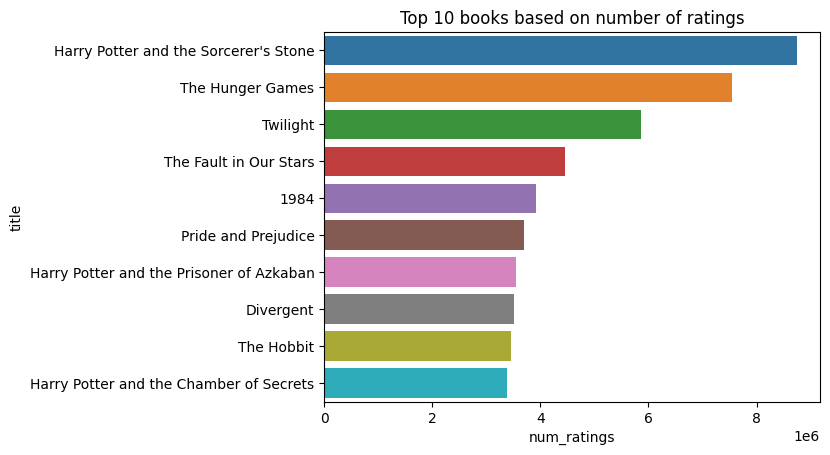

In [26]:
# Top 10 books based on number of ratings

top_books = df.nlargest(10, ['num_ratings']).set_index('title')['num_ratings']
sb.barplot(top_books, top_books.index)
plt.title('Top 10 books based on number of ratings')

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(0, 0, '3.94'),
  Text(1, 0, '3.95'),
  Text(2, 0, '3.98'),
  Text(3, 0, '3.99'),
  Text(4, 0, '4.03'),
  Text(5, 0, '4.04'),
  Text(6, 0, '4.05'),
  Text(7, 0, '4.06'),
  Text(8, 0, '4.08'),
  Text(9, 0, '4.09'),
  Text(10, 0, '4.11'),
  Text(11, 0, '4.12'),
  Text(12, 0, '4.14'),
  Text(13, 0, '4.15'),
  Text(14, 0, '4.16')])

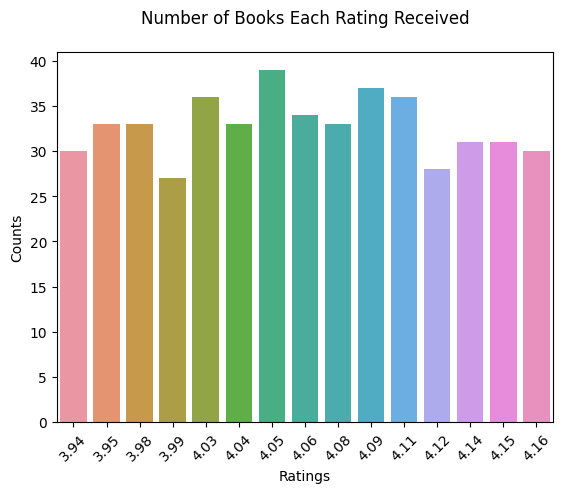

In [27]:
#books count based on ratings
sb.barplot(df['rating'].value_counts().head(15).index, df['rating'].value_counts().head(15))
plt.title('Number of Books Each Rating Received\n')
plt.xlabel('Ratings')
plt.ylabel('Counts')
plt.xticks(rotation=45)

We can observe that 4.05 is highest rating frequency for book present in given dataset

In [28]:
df["num_followers"] = df["num_followers"].apply(lambda x: x.replace(",", "").replace("k","").replace(" followers",""))

In [29]:
df['num_followers']= df['num_followers'].astype(float)

Text(0.5, 1.0, 'top author based on number of followers')

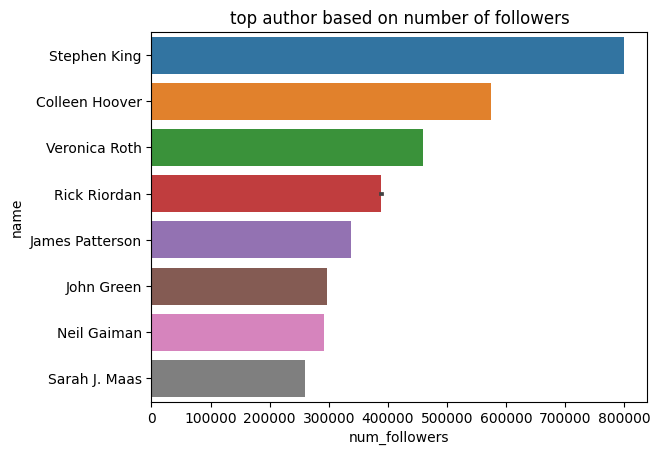

In [30]:
sb.barplot(x = 'num_followers',y = 'name', data = df.sort_values(by=['num_followers'],ascending=False)[:100])
plt.title("top author based on number of followers")

#### Data Preprocessing

In [31]:
#required libraries
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error


In [32]:
df["num_reviews"] = df["num_reviews"].apply(lambda x: x.replace(",", ""))
df['num_reviews'] = df['num_reviews'].astype(int)

In [34]:
features = df.drop(['synopsis','rating'],axis= 1)
y = df[['rating']]

In [35]:
#Categorical Encoding
features.dtypes

title             object
name              object
num_ratings        int64
num_reviews        int64
num_followers    float64
genre             object
dtype: object

In [36]:
le = LabelEncoder()
features['title'] = le.fit_transform(features['title'])
features['name'] = le.fit_transform(features['name'])
features['genre'] = le.fit_transform(features['genre'])

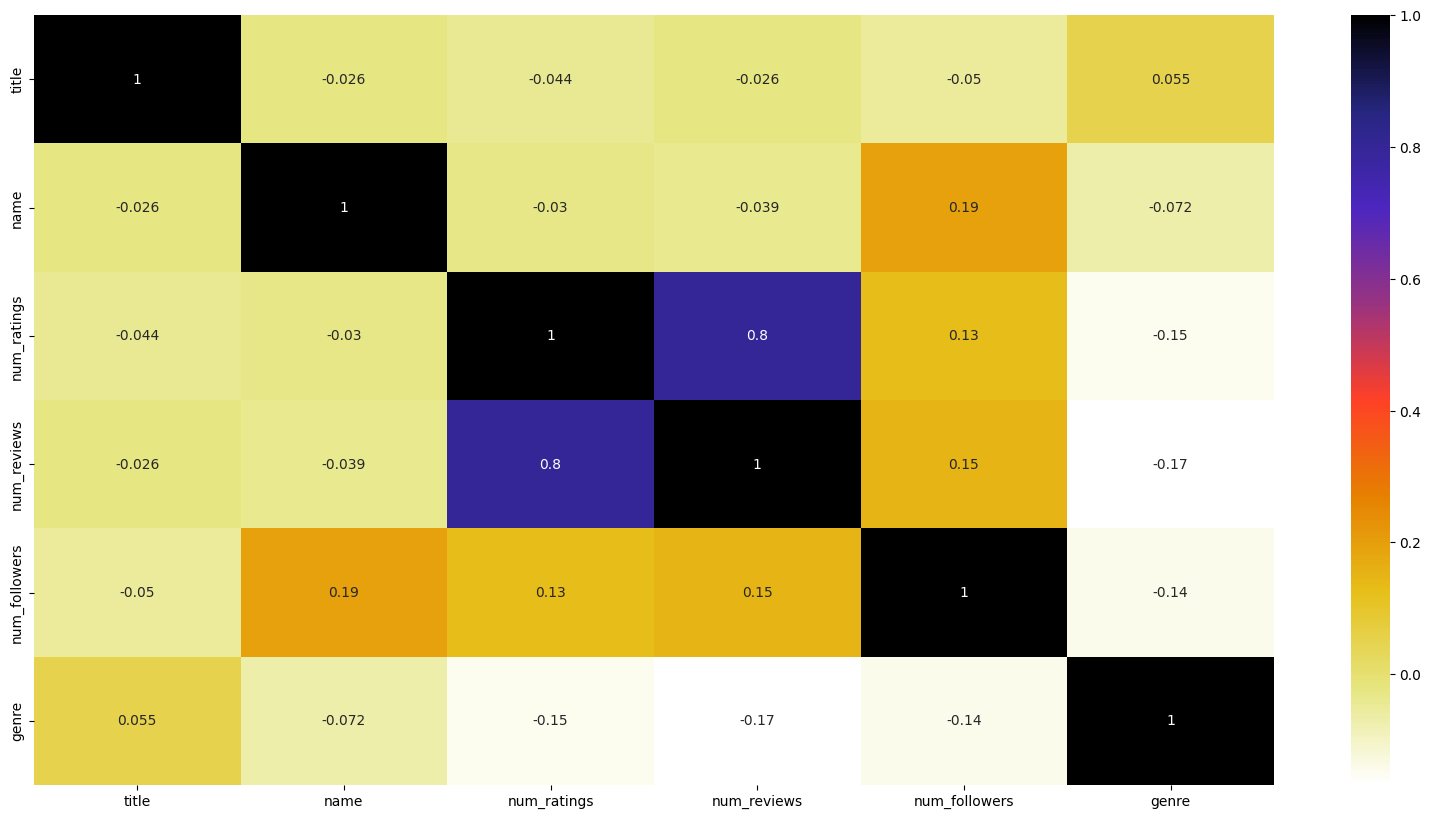

In [37]:
#feature selection using correlation heatmap
plt.figure(figsize=(20,10))
cor = features.corr()
sb.heatmap(cor, annot=True, cmap=plt.cm.CMRmap_r)
plt.show()

We can observe that number of ratings and reviwes highly correlated each so we can use either of one,lets drop number of reviews

In [38]:
features = features.drop(['num_reviews'],axis = 1)

In [39]:
## Model traing

x_train,x_test,y_train,y_test = train_test_split(features,y,test_size = 0.2,random_state= 42)

In [40]:
models = {"LinearRegression": LinearRegression(),
          "RandomForestRegressor": RandomForestRegressor(n_estimators = 100),
         "Adaboost": AdaBoostRegressor(n_estimators=100),
         "XGBOOST":XGBRegressor(seed=42)}

def fit_and_score(models,x_train,y_train,x_test,y_test):
    model_scores = {}
    model_test_score = {}
    for name, model in models.items():
        model.fit(x_train,y_train)
        model_scores[name] = model.score(x_train,y_train)
        model_test_score[name] = model.score(x_test,y_test)
    print("Train score" ,model_scores)
    print("Test score",model_test_score)

model_scores = fit_and_score(models, x_train,y_train,x_test,y_test)

model_scores

/tmp/ipykernel_253/4014286085.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x_train,y_train)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train score {'LinearRegression': 0.11231604476943025, 'RandomForestRegressor': 0.9020574905693594, 'Adaboost': 0.21958807469553432, 'XGBOOST': 0.9733386092681411}
Test score {'LinearRegression': 0.12783199189248617, 'RandomForestRegressor': 0.27495741677292207, 'Adaboost': 0.1124123614761039, 'XGBOOST': 0.2720177425260778}


we can observe that XGBOOST Regressor shows best traing score lets consider XGB and tune it for further analysis

In [41]:
params = { 
    'max_depth': [5,10], # Maximum tree depth for base learners
    'learning_rate': [0.01, 0.02], # Learning rate
    'n_estimators': [100, 500] # Number of gradient boosted trees
}


model = XGBRegressor(seed=42)

xgb = GridSearchCV(estimator=model, param_grid=params, cv=5)
xgb.fit(x_train,y_train)


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None, ...),
             param_grid={'learning_rate': [0.01, 0.02], 'max_depth': [5, 10],
                         'n_estimators': [100, 500]})

In [42]:
xgb.best_estimator_


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.02, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, ...)

In [44]:
import math
y_actual = y_test
y_pred = pd.DataFrame(xgb.best_estimator_.predict(x_test),columns = ['Prediction'])
 
MSE = mean_squared_error(y_actual, y_pred)
RMSE = math.sqrt(MSE)
r2 = r2_score(y_actual, y_pred)
print("Root Mean Square Error", round(RMSE,3))
print("Training score",round(xgb.best_estimator_.score(x_train,y_train),2))
print("Test score",round(xgb.best_estimator_.score(x_test,y_test),2))
print("r squred score",round(r2,2))

Root Mean Square Error 0.203
Training score 0.69
Test score 0.32
r squred score 0.32


we can observe that test score as been increased from 0.27 to 0.32 after tuning the model

In [45]:
y_test = y_test.reset_index(drop =True)
y_pred = y_pred.reset_index(drop =True)
predictions = pd.concat([y_test,y_pred],axis = 1)

In [46]:
predictions

,rating,Prediction
0,4.19,4.037724
1,4.07,3.899351
2,3.94,4.065886
3,3.73,3.863857
4,3.80,3.959116
...,...,...
303,3.89,3.907083
304,4.29,4.332120
305,3.98,3.925782
306,4.30,4.189685


Text(0.5, 1.0, 'Prediction vs actual ratings')

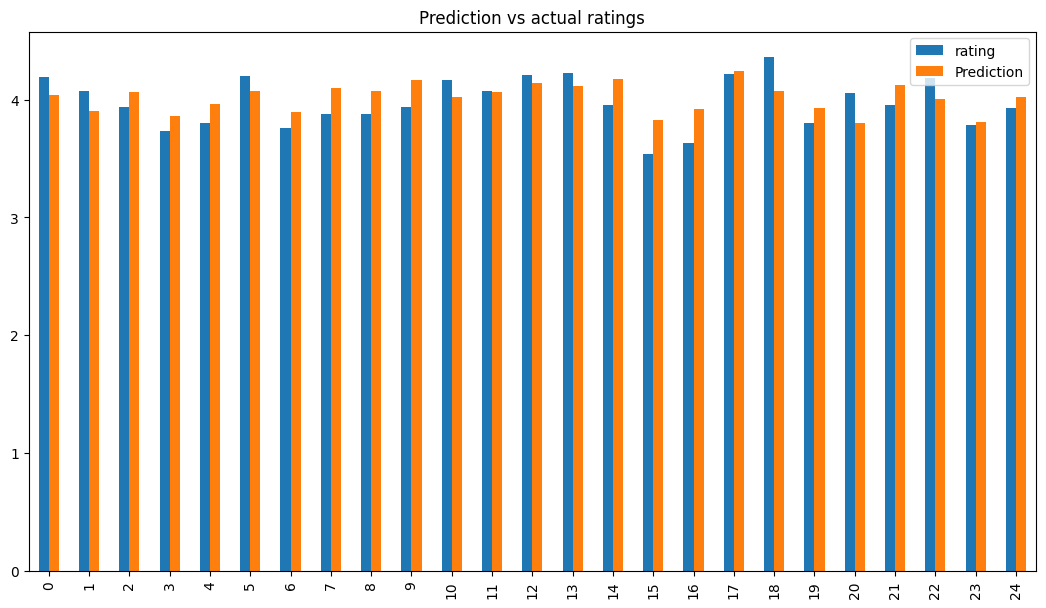

In [47]:
predictions[:25].plot(kind='bar', figsize=(13, 7))
plt.title('Prediction vs actual ratings')